# Wind influence on sea level at the Dutch coast

In [263]:
import sys
sys.path.append('../code')
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

import SeaLevelContrib as slc

In [229]:
importlib.reload(slc)

<module 'SeaLevelContrib' from '../code/SeaLevelContrib.py'>

### Read data from a sea level budget

In [230]:
data_dir = '../outputs/'

In [231]:
df = pd.read_csv(f'{data_dir}SLBudget_Steric4000m_ERA5_1979_2018_withLocSteric.csv')
df = df.set_index('time')
df[:10]

,Total,LocSteric,GloSteric,GIA,Glaciers,Antarctica,Greenland,TWS,Nodal,Wind,Pressure,Obs
time,,,,,,,,,,,,
1979,0.000000,-0.127019,0.127019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1980,0.261059,-0.307320,-0.101641,0.036833,0.000127,0.009419,0.001574,0.197184,0.304267,1.208551,-1.087937,2.733333
1981,5.176747,2.240077,-0.140368,0.073667,0.008054,0.018659,0.008711,0.149578,0.500829,3.132248,-0.814706,6.133333
1982,1.409847,2.830651,-0.147858,0.110500,0.039090,0.027848,0.015204,0.164888,0.567497,-0.440317,-1.757657,3.766667
1983,7.966499,2.693514,-0.100723,0.147333,0.014901,0.037117,0.016050,0.213123,0.496748,6.344351,-1.895916,7.516667
1984,2.461686,2.521132,0.022962,0.184167,0.029445,0.046594,0.011644,0.138241,0.296567,0.083898,-0.872962,1.283333
1985,1.854809,1.680297,0.226352,0.221000,0.044824,0.056408,0.011472,0.125809,-0.010451,0.931689,-1.432591,1.583333
1986,0.011999,1.634606,0.363131,0.257833,0.067080,0.066689,0.014053,0.158246,-0.389651,-0.716008,-1.443981,0.933333
1987,1.462292,4.972411,0.379434,0.294667,0.067597,0.077566,0.010301,0.355293,-0.798230,-1.838344,-2.058401,0.183333


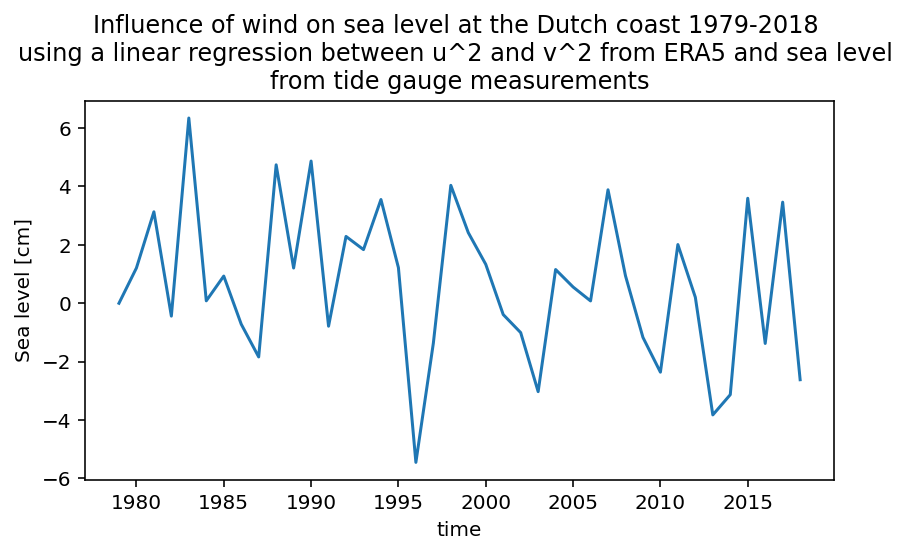

In [232]:
ax = df['Wind'].plot()
ax.set_ylabel('Sea level [cm]')
ax.set_title('Influence of wind on sea level at the Dutch coast 1979-2018 \n'+ 
             'using a linear regression between u^2 and v^2 from ERA5 and sea level \n'+
             'from tide gauge measurements')
plt.tight_layout()

#plt.savefig('../figures/WindInfluenceOnSeaLevelDutchCoast.pdf', dpi=150)

### Compare regression with GTSM and WAQUA

In [235]:
wind_pressure_df = pd.DataFrame(df['Wind'] + df['Pressure'], columns=['regression'])
wind_pressure_df['regression'] = wind_pressure_df['regression'] - wind_pressure_df['regression'].mean(axis=0)

In [234]:
tg_id = [20, 22, 23, 24, 25, 32] # Zeespiegelmonitor stations

In [236]:
# Read WAQUA (Data from Nina)
for idx, i in enumerate(tg_id):
    if idx == 0:
        waqua_df = slc.make_waqua_df(i).rename(columns={'WindPressure':i})
    else:
        waqua_df[i] = slc.make_waqua_df(i).rename(columns={'WindPressure':i})
waqua_df['mean'] = waqua_df.mean(axis=1)

In [237]:
# Read GTSM (Data from Fedor, soon on Zenodo)
for idx, i in enumerate(tg_id):
    if idx == 0:
        gtsm_df = slc.make_gtsm_df(i,'surge').rename(columns={'WindPressure':i})
    else:
        gtsm_df[i] = slc.make_gtsm_df(i,'surge').rename(columns={'WindPressure':i})
gtsm_df['mean'] = gtsm_df.mean(axis=1)

Remark: GTSM 'surge' and 'waterlevel' variables are almost exactly the same for yearly averages

In [238]:
wind_pressure_df['waqua'] = waqua_df['mean'] - waqua_df['mean'].mean()
wind_pressure_df['gtsm'] = gtsm_df['mean'] - gtsm_df['mean'].mean()

In [239]:
wind_pressure_df[-10:]

,regression,waqua,gtsm
time,,,
2009,-1.032617,-1.682023,-0.958096
2010,-2.022823,-3.555310,-2.562685
2011,0.447186,0.281165,0.809782
2012,-0.301462,-0.949083,-0.219925
2013,-4.450001,-2.911335,-2.818971
2014,-2.041841,-2.022603,-0.402661
2015,1.761847,2.072049,1.895627
2016,-2.415011,NaN,-2.230952
2017,2.438648,NaN,1.828412


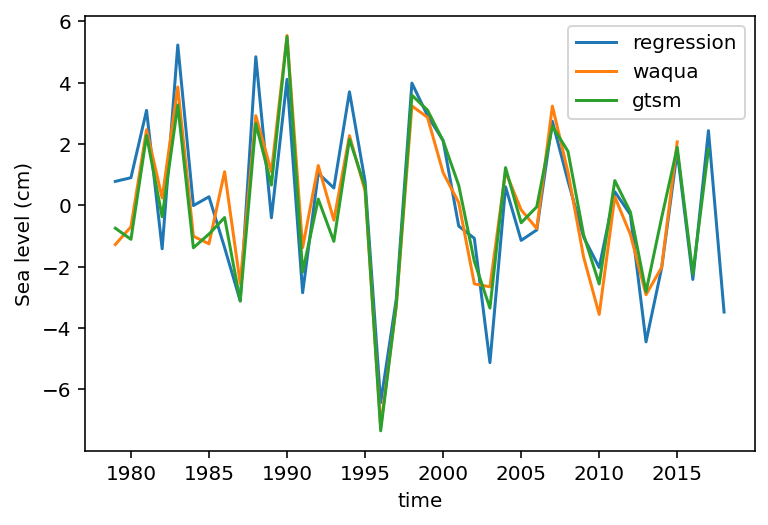

In [256]:
wind_pressure_df.plot()
plt.ylabel('Sea level (cm)');

### Plot differences

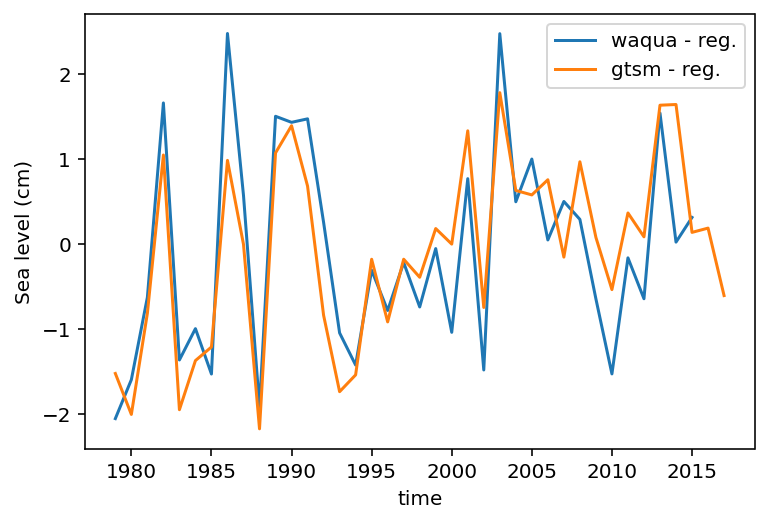

In [272]:
diff_df = wind_pressure_df.copy()
diff_df['waqua'] = diff_df['waqua'] - diff_df['regression']
diff_df['gtsm'] = diff_df['gtsm'] - diff_df['regression']
del(diff_df['regression'])
diff_df.rename(columns={'waqua':'waqua - reg.','gtsm':'gtsm - reg.'}).plot()
plt.ylabel('Sea level (cm)');

### Compute linear trends

In [269]:
for col in wind_pressure_df.columns:
    print(f'Linear trend (mm/y) in {col}:')
    lin_trend = linregress(wind_pressure_df.index[:-3], 
                           wind_pressure_df[col][:-3]*10)  # Convert from cm to mm
    print(lin_trend.slope)

Linear trend (mm/y) in regression:
-0.6251893556476398
Linear trend (mm/y) in waqua:
-0.43683508653220215
Linear trend (mm/y) in gtsm:
-0.11291907576139303


The linear trend is very sensitive to the method used to compute the wind effect on sea level